In [1]:
# necessary packages
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import os
import pickle

from skimage.measure import label
from skimage.exposure import histogram
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import white_tophat,black_tophat
from skimage.morphology import reconstruction,remove_small_holes,remove_small_objects

# optional package
# from scipy import ndimage as ndi
# from skimage.filters import sobel
# from skimage.filters import meijering

In [2]:
#pre-processing
def contrastStretch(img, a=0, b=255):
    c = np.min(img)
    d = np.max(img)
    if not (d-c):
        return img
    stretch = (b-a)/(d-c)    #stretch ratio
    return np.round((img-c)*stretch+a).astype(np.uint8)

def intensityHistogram(img):
    y,x = histogram(img)
    plt.figure(figsize=(8,6))         # plot the histogram
    plot = plt.bar(x, y, width = 0.8, align='center')
    plt.title('Intensity Histogram',fontsize=20)
    plt.ylabel('h(i)',fontsize=18)
    plt.xlabel('pixel intensity values',fontsize=18)
    return plot

def drawBoundingBox(image,img_labels,cur_id,color,mitosis= []):
    unique_label1 = cur_id
#     print("draw box:", cur_id)
#     print("cell ID:", unique_label1)
    centers = []
    out_img = image.copy()
    out_img = contrastStretch(cv2.cvtColor(out_img,cv2.COLOR_GRAY2BGR)).astype(np.uint8)
        
    for label in unique_label1:
        if mitosis and label in mitosis:
            for i in mitosis:
                x, y, w, h = cv2.boundingRect((img_labels==i).astype(np.uint8))
                center = (int(x + w/2),int(y + h/2))
                centers.append(center)
                cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
        elif mitosis and label not in mitosis:
            x, y, w, h = cv2.boundingRect((img_labels==label).astype(np.uint8))
            center = (int(x + w/2),int(y + h/2))
            centers.append(center)
            cv2.rectangle(out_img,(x,y),(x+w,y+h),color,2)
        else:
            x, y, w, h = cv2.boundingRect((img_labels==label).astype(np.uint8))
            center = (int(x + w/2),int(y + h/2))
            centers.append(center)
            cv2.rectangle(out_img,(x,y),(x+w,y+h),color,2)
    return centers,out_img

def fakeUltimate(img,iteration=True):
    S = np.ones((3,3))
    n_labels = np.unique(label(img)).shape[0]
    if n_labels<=1: # 1 label for background
        return img
    
    while True and iteration:
        new_img = cv2.erode(img, S)
        new_n_labels = np.unique(label(new_img)).shape[0]
        if new_n_labels<n_labels:
            break
        n_labels = new_n_labels
        img = new_img
        if type(iteration) is int:
            iteration-=1
    return img

def ultimateErosion(mask,iteration=True):
    labels = label(mask)
    retVal = np.zeros_like(labels)
    for i in np.unique(labels)[1:]:
        retVal+=fakeUltimate((labels==i).astype(np.uint8),iteration)
    return retVal

def removeSmallLabel(labels, t):
    for i in np.unique(labels):
        if np.sum(labels==i) < t:
            labels = np.where(labels==i,0,labels)
    return labels

def Segmentation(img,cell_size,binary_thresh=None,noise_size=5,label_thresh=0,blackHat=True,whiteHat=True):
    if blackHat:
        img = img+black_tophat(img,selem=np.ones((noise_size,noise_size)))
    if whiteHat:
        img = white_tophat(img,selem=np.ones((cell_size,cell_size)))
    img = cv2.GaussianBlur(img, (9,9), 1)
    img = contrastStretch(img)
    if binary_thresh is None:
        binary_thresh=threshold_otsu(img)
    mask = remove_small_objects(img>binary_thresh,label_thresh)
    Seed = ultimateErosion(mask)
    ws_labels = watershed(mask,markers=label(Seed),mask=mask)
    ws_labels = removeSmallLabel(ws_labels,label_thresh)
    return ws_labels

In [10]:
def cost(cnt1, cnt2,ellipse1, ellipse2, img_shape):
    area1 = cnt1[2]*cnt1[3]
    area2 = cnt2[2]*cnt2[3]
    overlap_x = min(cnt1[0]+cnt1[2],cnt2[0]+cnt2[2])-max(cnt1[0],cnt2[0])
    overlap_y = min(cnt1[1]+cnt1[3],cnt2[1]+cnt2[3])-max(cnt1[1],cnt2[1])
    if overlap_x <0 or overlap_y < 0:
        overlap_area=0
    else:
        overlap_area=overlap_x*overlap_y
    e_area = 1-((np.square(overlap_area))/(area1*area2))
    center1 = np.array([cnt1[0]+cnt1[2]/2, cnt1[1]+cnt1[3]/2])
    center2 = np.array([cnt2[0]+cnt2[2]/2, cnt2[1]+cnt2[3]/2])
    e_movement = abs(cv2.norm(center1,center2,cv2.NORM_L2)/np.sqrt(img_shape[0]**2+img_shape[1]**2))
    if ellipse1[1][0] * ellipse1[1][1] == 0 or ellipse2[1][0] * ellipse2[1][1] == 0:
        return 0.55*e_movement+0.45*e_area
    eccentricity1 = (2*np.pi*ellipse1[1][0]+4*(ellipse1[1][1]-ellipse1[1][0]))**2/((np.pi*ellipse1[1][0]*ellipse1[1][1])**2*4*np.pi)
    eccentricity2 = (2*np.pi*ellipse2[1][0]+4*(ellipse2[1][1]-ellipse2[1][0]))**2/((np.pi*ellipse2[1][0]*ellipse2[1][1])**2*4*np.pi)
    e_deformation = abs(eccentricity1-eccentricity2)/np.sqrt(eccentricity1**2+eccentricity2**2)
    return 0.5*e_movement+0.4*e_area+0.1*e_deformation
#     return e_movement

def tracking(prev,lat, prev_label, lat_label, prev_trajectory, center,thresh):
    unique_label1 = [i for i in np.unique(prev_label) if i > 0]
    unique_label2 = [i for i in np.unique(lat_label) if i > 0]
    mat = []
    trajectory = {}
    for i in unique_label2:
        cnt2 = cv2.boundingRect((lat_label==i).astype(np.uint8))
        points2 = cv2.findNonZero((lat_label==i).astype(np.uint8))
        ellipse2 = cv2.fitEllipse(points2)
        new_mat = []
        for j in unique_label1:
            cnt1 = cv2.boundingRect((prev_label==j).astype(np.uint8))
            points1 = cv2.findNonZero((prev_label==j).astype(np.uint8))
            ellipse1 = cv2.fitEllipse(points1)
            new_mat.append(cost(cnt1, cnt2,ellipse1,ellipse2, prev.shape))
        mat.append(new_mat)
    cost_matrix = np.matrix(mat)

#     out_img2 = contrastStretch(cv2.cvtColor(lat,cv2.COLOR_GRAY2BGR)).astype(np.uint8)
    path2 = lat.copy()
#     thresh = np.quantile(np.array(np.min(cost_matrix,axis=1)),thresh)
    for i in range(len(cost_matrix)):
        cnt2 = cv2.boundingRect((lat_label==unique_label2[i]).astype(np.uint8))
        center2 = np.array([cnt2[0]+cnt2[2]/2, cnt2[1]+cnt2[3]/2])
        if tuple(center2) not in trajectory:
            trajectory[tuple(center2)]= [cnt2,[]]
        if tuple(center2) not in center and np.min(cost_matrix[i]) <= thresh:
            j = np.argmin(cost_matrix[i])
            cnt1 = cv2.boundingRect((prev_label==unique_label1[j]).astype(np.uint8))
            center1 = np.array([cnt1[0]+cnt1[2]/2, cnt1[1]+cnt1[3]/2])
            if tuple(center1) not in prev_trajectory or not prev_trajectory[tuple(center1)][1]:
                trajectory[tuple(center2)][1].append([tuple(center1)])
            else:
                for i in prev_trajectory[tuple(center1)][1]:
                    trajectory[tuple(center2)][1].append([tuple(center1)]+i)
    for i in trajectory:
        for j in range(len(trajectory[i][1])):
            cv2.line(path2, (int(i[0]), int(i[1])),\
                     (int(trajectory[i][1][j][0][0]), int(trajectory[i][1][j][0][1])), (255,0,0),3)
            for k in range(1,len(trajectory[i][1][j])):
                cv2.line(path2, (int(trajectory[i][1][j][k-1][0]), int(trajectory[i][1][j][k-1][1])),\
                         (int(trajectory[i][1][j][k][0]), int(trajectory[i][1][j][k][1])), (255,0,0),3)
    return path2, trajectory

In [4]:
#DIC 123
#FLUO:133
#Phc: 230

In [5]:
from skimage import measure
from skimage.measure import label
def cost_matrix(prev,lat, lat_label,prev_label):
    unique_label1 = [i for i in np.unique(prev_label) if i > 0]
    unique_label2 = cur_id
    mat = []
    trajectory = {}
    for i in unique_label2:
        cnt2 = cv2.boundingRect((lat_label==i).astype(np.uint8))
        points2 = cv2.findNonZero((lat_label==i).astype(np.uint8))
        ellipse2 = cv2.fitEllipse(points2)
        new_mat = []
        for j in unique_label1:
            cnt1 = cv2.boundingRect((prev_label==j).astype(np.uint8))
            points1 = cv2.findNonZero((prev_label==j).astype(np.uint8))
            ellipse1 = cv2.fitEllipse(points1)
            new_mat.append(cost(cnt1, cnt2,ellipse1,ellipse2, prev.shape))
        mat.append(new_mat)
    cost_matrix1 = np.matrix(mat)
    return cost_matrix1

def draw_id(cur_img,cur_img_mask,cur_id):
    id_mi = {}
    id_center = {}
    regions = measure.regionprops(cur_img_mask,intensity_image=cur_img)
    for i in range(len(cur_id)):
        id_mi[cur_id[i]] = regions[i].mean_intensity
#         print(f"{cur_id[i]:}",regions[i].mean_intensity)
        x,y,w,h = cv2.boundingRect((cur_img_mask==cur_id[i]).astype(np.uint8))
        center = (x+w/2,y+h/2)
        id_center[cur_id[i]] = center
#         cv2.putText(cur_img, str(cur_id[i]),(int(center[0]),int(center[1])), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2)
    return id_center,id_mi

def w_h_diff(img_cur_mask, cell_id):
    x,y,w,h = cv2.boundingRect((img_cur_mask==cell_id).astype(np.uint8))
    return w - h

def start_mitosis(img_cur_mask,id_mi,thresh):
    start = []
    parent = []
    for i in id_mi:
        if id_mi[i] > thresh and -10 < w_h_diff(img_cur_mask, i) < 10:
            start.append(i)
        elif id_mi[i] > thresh:
            parent.append(i)
    return parent,start

def judge_mitosis(cur_img_mask, cur_id,last_id):
    id_center = {}
    area = []
    parent = []
    child = []
    for i in cur_id:
        if i not in last_id:
            child.append(i)
    for i in last_id:
        if i not in cur_id:
            parent.append(i)
    return parent,child

def cal_area(img_mask_cur, cur_id,img_mask_last,last_id):
    id_cur_area = {}
    id_last_area = {}
    id_diff_area = {}
    for i in cur_id:
        cnt = cv2.boundingRect((img_mask_cur==i).astype(np.uint8))
        id_cur_area[i] = cnt[2] * cnt[3]
    for j in last_id:
        cnt2 = cv2.boundingRect((img_mask_last==j).astype(np.uint8))
        id_last_area[j] = cnt2[2] * cnt2[3]
    for i in id_cur_area:
        for j in id_last_area:
            if i == j:
                id_diff_area[i] = id_last_area[i] - id_cur_area[i]
#     print("diff last and cur area:",id_diff_area)
    return id_diff_area

def seg_err_cor(cur_id,last_id,next_id):
    for i in cur_id:
        if i not in last_id and i not in next_id:
            cur_id.remove(i)
            print("after correction:", cur_id)
    return cur_id
        
def overlap_area(img_cur_mask,img_last_mask,cur_id,last_id):
    id_overlap = {}
    for i in cur_id:
        for j in last_id:
            if i == j:
                cnt1 = cv2.boundingRect((img_last_mask==i).astype(np.uint8))
                cnt2 = cv2.boundingRect((img_cur_mask==i).astype(np.uint8))
                overlap_x = min(cnt1[0]+cnt1[2],cnt2[0]+cnt2[2])-max(cnt1[0],cnt2[0])
                overlap_y = min(cnt1[1]+cnt1[3],cnt2[1]+cnt2[3])-max(cnt1[1],cnt2[1])
                id_overlap[i] = overlap_x * overlap_y
                continue
    print("id_overlap:",id_overlap)
    return id_overlap

In [6]:
def show_image(img):
    plt.imshow(img,"gray")
    plt.show()
    
def distance(coor1, coor2):
    x1, y1 = *coor1,
    x2, y2 = *coor2,
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

def task3(trajectoryList,coor):
    dict_val = trajectoryList[coor]
    if not dict_val[1]:
        return 0,0,0,0
    trajectory = [coor]
    trajectory.extend(dict_val[1][0])
    distanceList = []
    netDistance = distance(trajectory[0],trajectory[-1])
    for i in range(len(trajectory)-1):
        distanceList.append(distance(trajectory[i],trajectory[i+1]))
    totalDistance = sum(distanceList)
    speed = distanceList[0]
    ratio = totalDistance/netDistance
    return speed,totalDistance,netDistance,ratio

In [7]:
# get DIC images path and save in a list
datasets = 'COMP9517 20T2 Group Project Image Sequences/'

data = "DIC-C2DH-HeLa/"
data_label = "DIC-Label/"

seq1 = "Sequence 1/"
seq2 = "Sequence 2/"
seq3 = "Sequence 3/"
seq4 = "Sequence 4/"
img_file = []
img_mask = []
for mask_name in sorted(os.listdir(datasets+data_label+seq1)):
    if mask_name[0] != '.':
        img_mask.append(datasets+data_label+seq1+mask_name)
for file_name in sorted(os.listdir(datasets+data+seq1)):
    if file_name[0] != '.':
        img_file.append(datasets+data+seq1+file_name)
all_file = (sorted(img_file), sorted(img_mask))

In [8]:
# get Phc images path and save in a list
datasets = 'COMP9517 20T2 Group Project Image Sequences/'

data = "PhC-C2DL-PSC/"
data_label = "Phc-Label/"

seq1 = "Sequence 1/"
seq2 = "Sequence 2/"
seq3 = "Sequence 3/"
seq4 = "Sequence 4/"
img_file = []
img_mask = []
for mask_name in sorted(os.listdir(datasets+data_label+seq1)):
    if mask_name[0] != '.':
        img_mask.append(datasets+data_label+seq1+mask_name)
for file_name in sorted(os.listdir(datasets+data+seq1)):
    if file_name[0] != '.':
        img_file.append(datasets+data+seq1+file_name)
all_file = (sorted(img_file), sorted(img_mask))

In [99]:
# get Fluo images path and save in a list
datasets = 'COMP9517 20T2 Group Project Image Sequences/'

data = "Fluo-N2DL-HeLa/"
data_label = "Fluo-Label/"

seq1 = "Sequence 1/"
seq2 = "Sequence 2/"
seq3 = "Sequence 3/"
seq4 = "Sequence 4/"
img_file = []
img_mask = []
for mask_name in sorted(os.listdir(datasets+data_label+seq1)):
    if mask_name[0] != '.':
        img_mask.append(datasets+data_label+seq1+mask_name)
for file_name in sorted(os.listdir(datasets+data+seq1)):
    if file_name[0] != '.':
        img_file.append(datasets+data+seq1+file_name)
all_file = (sorted(img_file), sorted(img_mask))

In [11]:
# main part
# read original image
# read labels generated by "segmentation", the labels are saved in local disk (.npy file) beforehand due to time complexity
# total_trajectory saves trajectory of each cell in each frame
# output_imgs saves outputImg of each frame
datasets = 'COMP9517 20T2 Group Project Image Sequences/'

dataList = [("DIC-C2DH-HeLa/","DIC-Label/")]

seq1 = "Sequence 1/"
seq2 = "Sequence 2/"
seq3 = "Sequence 3/"
seq4 = "Sequence 4/"

for data,data_label in dataList:
    if 'DIC' in data:
        tracking_t = 0.5
        resolution=(512,512)
        videoName='DIC'
        fps=3.0
    elif 'Fluo' in data:
        tracking_t = 0.9
        resolution=(1100,700)
        videoName='Fluo'
        fps=3.0
    else:
        tracking_t = 0.9
        resolution=(720,576)
        videoName='Phc'
        fps=15.0
    img_file = []
    img_mask = []
    for mask_name in sorted(os.listdir(datasets+data_label+seq1)):
        if mask_name[0] != '.':
            img_mask.append(datasets+data_label+seq1+mask_name)
    for file_name in sorted(os.listdir(datasets+data+seq1)):
        if file_name[0] != '.':
            img_file.append(datasets+data+seq1+file_name)
    all_file = (sorted(img_file), sorted(img_mask))

    total_trajectory= []
    output_imgs = []
    for ind in range(1,len(img_file)):
        print(all_file[0][ind])
        img_cur = cv2.cvtColor(cv2.imread(all_file[0][ind]),cv2.COLOR_RGB2GRAY)
        img_last = cv2.cvtColor(cv2.imread(all_file[0][ind - 1]),cv2.COLOR_RGB2GRAY)
        if 'DIC' in all_file[1][ind]:
            img_mask_cur = cv2.imread(all_file[1][ind],-1)
            img_mask_last = cv2.imread(all_file[1][ind - 1],-1)
        else:
            img_mask_cur = np.load(all_file[1][ind])    
            img_mask_last = np.load(all_file[1][ind - 1])
        cur_id = [i for i in np.unique(img_mask_cur) if i > 0]
        last_id = [i for i in np.unique(img_mask_last) if i > 0]
        cost_matrix1 = cost_matrix(img_last,img_cur, img_mask_cur,img_mask_last)
        if ind != len(img_file) - 1:
            if 'DIC' in all_file[1][ind]:
                img_mask_next =cv2.imread(all_file[1][ind + 1],-1)
            else:
                img_mask_next =np.load(all_file[1][ind + 1])
            next_id = [i for i in np.unique(img_mask_next) if ind > 0]
            cur_id = seg_err_cor(cur_id, last_id, next_id)
        id_center, id_mi = draw_id(img_cur,img_mask_cur,cur_id)
        id_diff_area = cal_area(img_mask_cur, cur_id,img_mask_last,last_id)
        if 'DIC' in all_file[1][ind]:
            parent,child = start_mitosis(img_mask_cur,id_mi, 123)
        elif 'Fluo' in all_file[1][ind]:
            parent,child = start_mitosis(img_mask_cur,id_mi, 133)
        else:
            parent,child = start_mitosis(img_mask_cur,id_mi, 230)
        if parent:
            child = child + parent
        p,c = judge_mitosis(img_mask_cur,cur_id,last_id)
        if len(c) == 2:
            if c[0] not in child and c[1] in child:
                child = child + [c[0]]
            if c[1] not in child and c[0] in child:
                child = child + [c[1]]
        center = []
        if len(child) > 1:
            for i in child:
                center.append(id_center[i])
        cen_cur,output_cur = drawBoundingBox(img_cur,img_mask_cur,cur_id, (255,0,0),child)
        cen_last,output_last = drawBoundingBox(img_last,img_mask_last,last_id,(255,0,0),child)
        print(center)
        if ind == 1:
            path, trajectory = tracking(img_last,output_cur,img_mask_last,img_mask_cur,[],center,tracking_t)
            total_trajectory.append(trajectory)
        else:
            path, trajectory = tracking(img_last,output_cur,img_mask_last,img_mask_cur, total_trajectory[-1],center,tracking_t)
            total_trajectory.append(trajectory)
        cv2.putText(path, f"cell#: {len(cur_id)}", (0,25),cv2.FONT_ITALIC,1,(255,255,255),2)
        cv2.putText(path, f"frame#: {ind}", (0,75),cv2.FONT_ITALIC,1,(255,255,255),2)
        cv2.putText(path, f"dividing#: {len(child)}", (0,125),cv2.FONT_ITALIC,1,(255,255,255),2)
        output_imgs.append(path)
        
    with open(videoName+'Seq1.pkl', 'wb') as f:
        pickle.dump(total_trajectory, f, pickle.HIGHEST_PROTOCOL)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(videoName+'Seq1.avi',fourcc,fps,resolution,True)
    for img in output_imgs: 
        out.write(img)
        cv2.waitKey(10)
    out.release()

COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t001.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t002.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t003.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t004.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t005.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t006.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t007.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t008.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t009.tif
after correction: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11]
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t010.tif
[]
COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t011.tif
[(238.5, 406.0), (178.0, 434.5)]
COMP9517 20T2 Group Project 

COMP9517 20T2 Group Project Image Sequences/DIC-C2DH-HeLa/Sequence 1/t083.tif
[]


In [171]:
img21 = output_imgs[21].copy()
img22 = output_imgs[22].copy()
img23 = output_imgs[23].copy()
img24 = output_imgs[24].copy()
img25 = output_imgs[25].copy()

In [172]:
mov21=task3(total_trajectory[21],(82.0, 354.0))

In [173]:
mov22=task3(total_trajectory[22],(76.0, 351.0))

In [174]:
mov23=task3(total_trajectory[23],(64.5, 340.5))

In [175]:
mov24=task3(total_trajectory[24],(56.0, 336.5))

In [176]:
mov25=task3(total_trajectory[25],(53.5, 349.0))

In [177]:
cv2.line(img21, (82, 354),(82, 354),(255,255,255),10)
dummy=cv2.putText(img21, f"Speed:{mov21[0]:5.2f}", (250,425),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img21, f"Total_dist:{mov21[1]:5.2f}", (250,450),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img21, f"Net_dist:{mov21[2]:5.2f}", (250,475),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img21, f"Ratio:{mov21[3]:5.2f}", (250,500),cv2.FONT_ITALIC,1,(255,255,255),2)

In [178]:
cv2.line(img22,(76, 351),(76, 351),(255,255,255),10)
dummy=cv2.putText(img22, f"Speed:{mov22[0]:5.2f}", (250,425),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img22, f"Total_dist:{mov22[1]:5.2f}", (250,450),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img22, f"Net_dist:{mov22[2]:5.2f}", (250,475),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img22, f"Ratio:{mov22[3]:5.2f}", (250,500),cv2.FONT_ITALIC,1,(255,255,255),2)

In [179]:
cv2.line(img23,(64, 340),(64, 340),(255,255,255),10)
dummy=cv2.putText(img23, f"Speed:{mov23[0]:5.2f}", (250,425),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img23, f"Total_dist:{mov23[1]:5.2f}", (250,450),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img23, f"Net_dist:{mov23[2]:5.2f}", (250,475),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img23, f"Ratio:{mov23[3]:5.2f}", (250,500),cv2.FONT_ITALIC,1,(255,255,255),2)

In [180]:
cv2.line(img24,(56, 336),(56, 336),(255,255,255),10)
dummy=cv2.putText(img24, f"Speed:{mov24[0]:5.2f}", (250,425),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img24, f"Total_dist:{mov24[1]:5.2f}", (250,450),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img24, f"Net_dist:{mov24[2]:5.2f}", (250,475),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img24, f"Ratio:{mov24[3]:5.2f}", (250,500),cv2.FONT_ITALIC,1,(255,255,255),2)

In [181]:
cv2.line(img25,(53, 349),(53, 349),(255,255,255),10)
dummy=cv2.putText(img25, f"Speed:{mov25[0]:5.2f}", (250,425),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img25, f"Total_dist:{mov25[1]:5.2f}", (250,450),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img25, f"Net_dist:{mov25[2]:5.2f}", (250,475),cv2.FONT_ITALIC,1,(255,255,255),2)
dummy=cv2.putText(img25, f"Ratio:{mov25[3]:5.2f}", (250,500),cv2.FONT_ITALIC,1,(255,255,255),2)

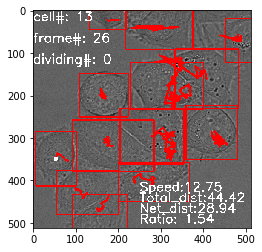

In [186]:
plt.imshow(img25)

In [189]:
motionFrame=[img21,img22,img23,img24,img25]
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('DICTask3.avi',fourcc,1.0,(512,512),True)
for img in motionFrame: 
    out.write(img)
out.release()